# MRMR Feature Selection on Breast Cancer Dataset

This notebook implements Minimum Redundancy Maximum Relevance (MRMR) feature selection on the Wisconsin breast cancer dataset.

## Import Libraries

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [6]:
# Load your CSV file
df = pd.read_csv('/Users/pofilla/Library/Mobile Documents/com~apple~CloudDocs/University/7th Term/Data Mining/Project/Breast Cancer Diagnostic Data Mining/Docs/data.csv')  # Replace with your actual file path

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nDataset info:")
print(df.info())

Dataset shape: (569, 32)

First few rows:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst

## Prepare Data

In [7]:
# Separate features and target
# Assuming the target column is 'diagnosis' or the last column
# Adjust column name if needed
X = df.drop(['id', 'diagnosis'], axis=1)  # Replace 'diagnosis' with your target column name
y = df['diagnosis']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nNumber of features: {X.shape[1]}")
print(f"Number of records: {X.shape[0]}")
print(f"\nTarget distribution:")
print(y.value_counts())

Features shape: (569, 30)
Target shape: (569,)

Number of features: 30
Number of records: 569

Target distribution:
diagnosis
B    357
M    212
Name: count, dtype: int64


## Train-Test Split (80-20)

In [8]:
# Split into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining target distribution:")
print(y_train.value_counts())
print(f"\nTest target distribution:")
print(y_test.value_counts())

Training set size: (455, 30)
Test set size: (114, 30)

Training target distribution:
diagnosis
B    285
M    170
Name: count, dtype: int64

Test target distribution:
diagnosis
B    72
M    42
Name: count, dtype: int64


## MRMR Feature Selection Implementation

In [9]:
def calculate_mutual_information(feature, target):
    """
    Calculate mutual information between a feature and target.
    MI measures how much knowing one variable tells us about another.
    """
    # Create bins for continuous features
    feature_bins = pd.cut(feature, bins=10, duplicates='drop')
    target_bins = target
    
    # Create contingency table
    contingency = pd.crosstab(feature_bins, target_bins)
    
    # Calculate probabilities
    pxy = contingency / contingency.sum().sum()
    px = pxy.sum(axis=1)
    py = pxy.sum(axis=0)
    
    # Calculate MI
    mi = 0
    for i in range(len(px)):
        for j in range(len(py)):
            if pxy.iloc[i, j] > 0:
                mi += pxy.iloc[i, j] * np.log2(pxy.iloc[i, j] / (px.iloc[i] * py.iloc[j]))
    
    return mi

In [10]:
def mrmr_feature_selection(X_train, y_train, num_features=10):
    """
    MRMR Feature Selection Algorithm
    Selects features that are highly relevant to target and have low redundancy.
    
    Parameters:
    - X_train: Training features
    - y_train: Training target
    - num_features: Number of features to select
    
    Returns:
    - selected_features: List of selected feature names
    - scores: MRMR scores for each selected feature
    """
    selected_features = []
    scores = []
    remaining_features = list(X_train.columns)
    
    print(f"Starting MRMR feature selection for {num_features} features...\n")
    
    # Step 1: Select first feature with maximum relevance to target
    relevances = {}
    for feature in remaining_features:
        mi = calculate_mutual_information(X_train[feature].values, y_train.values)
        relevances[feature] = mi
    
    first_feature = max(relevances, key=relevances.get)
    selected_features.append(first_feature)
    scores.append(relevances[first_feature])
    remaining_features.remove(first_feature)
    
    print(f"1. Selected: {first_feature}")
    print(f"   Relevance Score: {relevances[first_feature]:.4f}\n")
    
    # Step 2: Iteratively select remaining features
    for i in range(1, num_features):
        if not remaining_features:
            print("No more features to select!")
            break
        
        best_score = -np.inf
        best_feature = None
        best_relevance = None
        best_redundancy = None
        
        for feature in remaining_features:
            # Calculate relevance to target
            relevance = calculate_mutual_information(X_train[feature].values, y_train.values)
            
            # Calculate redundancy with already selected features
            redundancy = 0
            for selected in selected_features:
                mi = calculate_mutual_information(
                    X_train[feature].values,
                    X_train[selected].values
                )
                redundancy += mi
            
            redundancy = redundancy / len(selected_features)
            
            # MRMR Score = Relevance - Redundancy
            mrmr_score = relevance - redundancy
            
            if mrmr_score > best_score:
                best_score = mrmr_score
                best_feature = feature
                best_relevance = relevance
                best_redundancy = redundancy
        
        selected_features.append(best_feature)
        scores.append(best_score)
        remaining_features.remove(best_feature)
        
        print(f"{i+1}. Selected: {best_feature}")
        print(f"   Relevance: {best_relevance:.4f}")
        print(f"   Redundancy: {best_redundancy:.4f}")
        print(f"   MRMR Score: {best_score:.4f}\n")
    
    return selected_features, scores

## Run MRMR Feature Selection

In [11]:
# Select top 10 features using MRMR
num_features_to_select = 10
selected_features, mrmr_scores = mrmr_feature_selection(X_train, y_train, num_features_to_select)

Starting MRMR feature selection for 10 features...

1. Selected: perimeter_worst
   Relevance Score: 0.6491

2. Selected: area_se
   Relevance: 0.3012
   Redundancy: 0.8975
   MRMR Score: -0.5963

3. Selected: concavity_se
   Relevance: 0.0659
   Redundancy: 1.0442
   MRMR Score: -0.9782

4. Selected: perimeter_se
   Relevance: 0.2944
   Redundancy: 1.3656
   MRMR Score: -1.0712

5. Selected: radius_se
   Relevance: 0.3116
   Redundancy: 1.4926
   MRMR Score: -1.1811

6. Selected: fractal_dimension_se
   Relevance: 0.0370
   Redundancy: 1.3180
   MRMR Score: -1.2810

7. Selected: area_worst
   Relevance: 0.5692
   Redundancy: 2.1004
   MRMR Score: -1.5312

8. Selected: smoothness_se
   Relevance: 0.0264
   Redundancy: 1.7320
   MRMR Score: -1.7056

9. Selected: area_mean
   Relevance: 0.4979
   Redundancy: 2.2546
   MRMR Score: -1.7566

10. Selected: symmetry_se
   Relevance: 0.0542
   Redundancy: 1.9424
   MRMR Score: -1.8883



## Selected Features Summary

In [12]:
print(f"{'='*60}")
print(f"Top {num_features_to_select} Features Selected by MRMR:")
print(f"{'='*60}")
for i, (feat, score) in enumerate(zip(selected_features, mrmr_scores), 1):
    print(f"{i:2d}. {feat:30s} | Score: {score:8.4f}")

# Create summary dataframe
summary_df = pd.DataFrame({
    'Rank': range(1, len(selected_features) + 1),
    'Feature': selected_features,
    'MRMR Score': mrmr_scores
})

print(f"\n{summary_df.to_string(index=False)}")

Top 10 Features Selected by MRMR:
 1. perimeter_worst                | Score:   0.6491
 2. area_se                        | Score:  -0.5963
 3. concavity_se                   | Score:  -0.9782
 4. perimeter_se                   | Score:  -1.0712
 5. radius_se                      | Score:  -1.1811
 6. fractal_dimension_se           | Score:  -1.2810
 7. area_worst                     | Score:  -1.5312
 8. smoothness_se                  | Score:  -1.7056
 9. area_mean                      | Score:  -1.7566
10. symmetry_se                    | Score:  -1.8883

 Rank              Feature  MRMR Score
    1      perimeter_worst    0.649143
    2              area_se   -0.596273
    3         concavity_se   -0.978244
    4         perimeter_se   -1.071229
    5            radius_se   -1.181052
    6 fractal_dimension_se   -1.280981
    7           area_worst   -1.531197
    8        smoothness_se   -1.705555
    9            area_mean   -1.756626
   10          symmetry_se   -1.888261


## Train Model with Selected Features

In [13]:
# Prepare data with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Train Random Forest classifier
print(f"Training Random Forest Classifier with {num_features_to_select} selected features...\n")

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

print("Model trained successfully!")

Training Random Forest Classifier with 10 selected features...

Model trained successfully!


## Evaluate Model with Selected Features

In [14]:
# Make predictions
y_pred = clf.predict(X_test_scaled)

# Calculate accuracy
accuracy_selected = accuracy_score(y_test, y_pred)

print(f"{'='*60}")
print(f"Results with {num_features_to_select} Selected Features")
print(f"{'='*60}\n")

print(f"Accuracy: {accuracy_selected:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Results with 10 Selected Features

Accuracy: 0.9474

Classification Report:
              precision    recall  f1-score   support

           B       0.93      0.99      0.96        72
           M       0.97      0.88      0.93        42

    accuracy                           0.95       114
   macro avg       0.95      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114



## Compare with All Features

In [15]:
# Train model with all features
print(f"Training Random Forest Classifier with all {X_train.shape[1]} features...\n")

scaler_all = StandardScaler()
X_train_all_scaled = scaler_all.fit_transform(X_train)
X_test_all_scaled = scaler_all.transform(X_test)

clf_all = RandomForestClassifier(n_estimators=100, random_state=42)
clf_all.fit(X_train_all_scaled, y_train)

y_pred_all = clf_all.predict(X_test_all_scaled)
accuracy_all = accuracy_score(y_test, y_pred_all)

print(f"{'='*60}")
print(f"Comparison: All Features vs Selected Features")
print(f"{'='*60}\n")

print(f"Accuracy with all {X_train.shape[1]} features: {accuracy_all:.4f}")
print(f"Accuracy with {num_features_to_select} selected features: {accuracy_selected:.4f}")
print(f"Difference: {accuracy_all - accuracy_selected:.4f}")
print(f"\nFeature reduction: {X_train.shape[1]} → {num_features_to_select} ({(1 - num_features_to_select/X_train.shape[1])*100:.1f}% reduction)")

Training Random Forest Classifier with all 30 features...

Comparison: All Features vs Selected Features

Accuracy with all 30 features: 0.9737
Accuracy with 10 selected features: 0.9474
Difference: 0.0263

Feature reduction: 30 → 10 (66.7% reduction)


## Visualization

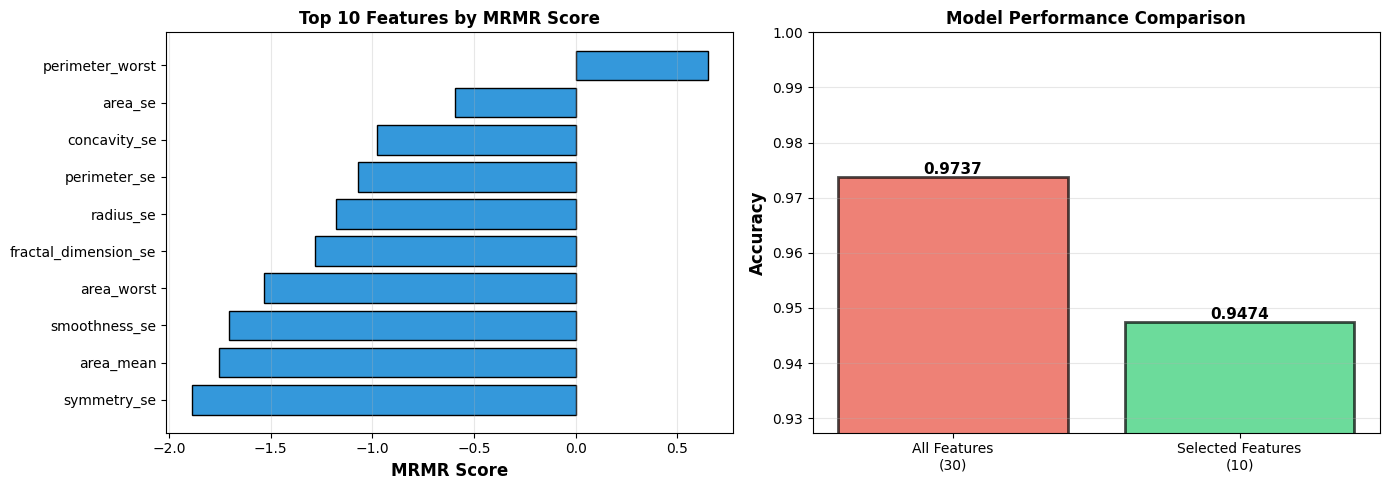

Visualization completed!


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: MRMR Scores
axes[0].barh(range(len(selected_features)), mrmr_scores, color='#3498db', edgecolor='black')
axes[0].set_yticks(range(len(selected_features)))
axes[0].set_yticklabels(selected_features)
axes[0].set_xlabel('MRMR Score', fontsize=12, fontweight='bold')
axes[0].set_title(f'Top {num_features_to_select} Features by MRMR Score', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Accuracy Comparison
categories = [f'All Features\n({X_train.shape[1]})', f'Selected Features\n({num_features_to_select})']
accuracies = [accuracy_all, accuracy_selected]
colors = ['#e74c3c', '#2ecc71']

bars = axes[1].bar(categories, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[1].set_title('Model Performance Comparison', fontsize=12, fontweight='bold')
axes[1].set_ylim([min(accuracies) - 0.02, 1.0])
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("Visualization completed!")

## Summary and Insights

In [17]:
print(f"\n{'='*70}")
print("MRMR FEATURE SELECTION - SUMMARY")
print(f"{'='*70}\n")

print(f"Dataset Information:")
print(f"  - Total records: {X.shape[0]}")
print(f"  - Total features: {X.shape[1]}")
print(f"  - Training set: {X_train.shape[0]} records")
print(f"  - Test set: {X_test.shape[0]} records")

print(f"\nMRMR Selection Results:")
print(f"  - Features selected: {num_features_to_select}")
print(f"  - Features reduced: {X_train.shape[1] - num_features_to_select}")
print(f"  - Reduction percentage: {(1 - num_features_to_select/X_train.shape[1])*100:.1f}%")

print(f"\nModel Performance:")
print(f"  - Accuracy (all features): {accuracy_all:.4f}")
print(f"  - Accuracy (selected features): {accuracy_selected:.4f}")
print(f"  - Difference: {accuracy_all - accuracy_selected:+.4f}")

if accuracy_selected >= accuracy_all - 0.01:
    print(f"\n✓ MRMR successfully selected a reduced feature set with comparable accuracy!")
else:
    print(f"\n⚠ Consider increasing the number of selected features for better performance.")


MRMR FEATURE SELECTION - SUMMARY

Dataset Information:
  - Total records: 569
  - Total features: 30
  - Training set: 455 records
  - Test set: 114 records

MRMR Selection Results:
  - Features selected: 10
  - Features reduced: 20
  - Reduction percentage: 66.7%

Model Performance:
  - Accuracy (all features): 0.9737
  - Accuracy (selected features): 0.9474
  - Difference: +0.0263

⚠ Consider increasing the number of selected features for better performance.
